In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import time
# import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
#import tensorflow as tf
# from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import torchvision
import cv2
import os

In [ ]:
ich = 3
G = 64
G0 = 64

In [ ]:
class RDB(nn.Module) :
  def __init__(self) :
    super(RDB,self).__init__()
    self.se1 = nn.Conv2d(in_channels=G,out_channels=G,kernel_size = (3,3),padding=1)
    self.se2 = nn.Conv2d(in_channels=2*G,out_channels=G,kernel_size = (3,3),padding=1)
    self.se3 = nn.Conv2d(in_channels=3*G,out_channels=G,kernel_size = (3,3),padding=1)
    self.se4 = nn.Conv2d(in_channels=4*G,out_channels=G,kernel_size = (3,3),padding=1)  
    self.se5 = nn.Conv2d(in_channels=5*G,out_channels=G,kernel_size = (3,3),padding=1)
    self.se6 = nn.Conv2d(in_channels=6*G,out_channels=G,kernel_size = (3,3),padding=1)
    self.se7 = nn.Conv2d(in_channels=7*G,out_channels=G,kernel_size = (1,1),padding=0)
  def forward(self,x) :
    o1 = self.se1(x)
    o1 = nn.ReLU()(o1)
    c1 = torch.cat((x,o1),dim=1)  
    o2 = self.se2(c1)
    o2 = nn.ReLU()(o2)
    c2 = torch.cat((c1,o2),dim=1)
    o3 = self.se3(c2)
    o3 = nn.ReLU()(o3)
    c3 = torch.cat((c2,o3),dim=1)  
    o4 = self.se4(c3)
    o4 = nn.ReLU()(o4)
    c4 = torch.cat((c3,o4),dim=1)
    o5 = self.se5(c4)
    o5 = nn.ReLU()(o5)
    c5 = torch.cat((c4,o5),dim=1)  
    o6 = self.se6(c5)
    o6 = nn.ReLU()(o6)
    c6 = torch.cat((c5,o6),dim=1)
    o7 = self.se7(c6)
    o8 = torch.add(o7,x)
    return o8



In [ ]:
och = 3
class RDN(nn.Module) :
  def __init__(self,nb) :
    super(RDN,self).__init__()
    self.num_blocks = nb
    self.se1 = nn.Conv2d(in_channels=ich,out_channels=G0,kernel_size = (3,3),padding=1)
    self.se2 = nn.Conv2d(in_channels=G0,out_channels=G0,kernel_size = (3,3),padding=1)
    self.rdbs = nn.ModuleList([RDB()])
    for i in range(self.num_blocks-1) :
      rdb = RDB()
      self.rdbs.append(rdb)
    self.gff1 = nn.Conv2d(in_channels=(self.num_blocks)*G,out_channels=G,kernel_size =(1,1))
    self.gff2 = nn.Conv2d(in_channels=G,out_channels=G,kernel_size =(3,3),padding=1)
    self.lastconv = nn.Conv2d(in_channels=G,out_channels=och,kernel_size = (3,3),padding=1)
  def forward(self, x):
    features = []
    o1 = self.se1(x)
    o2 = self.se2(o1)
    features.append(o1)
    features.append(o2)
    for i in range(len(self.rdbs)):
      o2 = self.rdbs[i](o2)
      features.append(o2)
    rdb_feats = features[2]
    for i in range(3,len(features)) :
      rdb_feats = torch.cat((rdb_feats,features[i]),dim=1)
    gff_o1 = self.gff1(rdb_feats)
    gff_o2 = self.gff2(gff_o1)
    dff_out = torch.add(gff_o2,features[0])
    output = torch.add(self.lastconv(dff_out),x) 
    return output
 


In [ ]:
device = 'cpu'
rdn = RDN(5).to(device)
#rdn.half().to(device)  # convert to half precision
#for layer in rdn.modules():
#  if isinstance(layer, nn.BatchNorm2d):
#    layer.float()

In [ ]:
from torchsummary import summary
summary(rdn, (3, 256, 256))

In [ ]:
def minibatch(i,f) :
  clean_imgs = []
  noisy_imgs = []
  for j in range(i,f+1) :
    j = str(j).zfill(5)
    clean_imgs.append(torch.from_numpy(np.asarray(cv2.imread('/content/drive/MyDrive/sar-images/clean_1c/' + str(j) + '.jpg')/255.0,dtype=np.float32)))
  for j in range(i,f+1) :
    j = str(j).zfill(5)
    noisy_imgs.append(torch.from_numpy(np.asarray(cv2.imread('/content/drive/MyDrive/sar-images/noisy_1c/' + str(j) + '.jpg')/255.0,dtype=np.float32)))
  clean_imgs = torch.stack(clean_imgs,dim=0)
  noisy_imgs = torch.stack(noisy_imgs,dim=0)
  return clean_imgs,noisy_imgs

In [ ]:
optimizer = torch.optim.Adam(rdn.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)
l1loss = nn.L1Loss()
checkpoint_dir1 = '/content/drive/MyDrive/rdn15_ckpts'

In [ ]:
!unzip '/content/drive/MyDrive/ckpt399.zip' 

Archive:  /content/drive/MyDrive/ckpt399.zip
  inflating: ckpt399                 


In [ ]:
device = 'cpu'
#Using 15,000 images for training
batch_sz = 1
itr = 15000/batch_sz
epochs = 500
for ep in range(epochs) :
  for i in range(int(itr)) :
    clean_imgs, noisy_imgs = minibatch(i*batch_sz+1,(i+1)*batch_sz)
    noisy_imgs = noisy_imgs.permute(0,3,1,2).to(device)
    clean_imgs = clean_imgs.permute(0,3,1,2).to(device)
    pred_clean = rdn(noisy_imgs)
    rdn.train()
    optimizer.zero_grad()
    loss = l1loss(pred_clean,clean_imgs)       
    loss.detach()
    loss.backward()         
    optimizer.step()
    print(i,'Loss',loss)
    if (i+1)%1000 == 0 :	
  	  checkpoint_prefix1 = os.path.join(checkpoint_dir1, "ckpt") 
  	  checkpoint_prefix1 = checkpoint_prefix1 + str(ep) + str(itr)
  	  torch.save({'model_state_dict': rdn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, checkpoint_prefix1)
  scheduler.step()

#For saving checkpoints every 10 epochs
 

In [ ]:
rdn.load_state_dict(torch.load('/content/ckpt399',map_location=torch.device('cpu'))['model_state_dict'])

<All keys matched successfully>

In [ ]:
#PSNR calculation
PSNR = 0
for i in range(1) :
  cl_img = torch.from_numpy(np.asarray(cv2.imread('/content/drive/MyDrive/sar-images/clean_1c/23009.jpg')/255.0,dtype=np.float32))
  no_img = torch.from_numpy(np.asarray(cv2.imread('/content/23009.jpg.png')/255.0,dtype=np.float32))
  tni = torch.unsqueeze(no_img,dim=0)
  tni = tni.permute(0,3,1,2)
  ncl = rdn(tni)
  ncl = ncl.permute(0,2,3,1)
  L = torch.max(cl_img)
  den = torch.mean(torch.square(torch.subtract(cl_img,ncl)))
  PSNR = 10*torch.log10(torch.square(L)/den)



In [ ]:
print(PSNR)

tensor(23.5792, grad_fn=<MulBackward0>)


In [ ]:
tci = ''
tni = '/23009.jpg.png'
tni = torch.unsqueeze(torch.from_numpy(np.asarray(cv2.imread(tni),np.float32)),dim=0)
tni = tni.permute(0,3,1,2)
cl = rdn(tni)
print(tni.shape)
print(cl.shape)
from google.colab.patches import cv2_imshow


torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [ ]:
tni = torch.squeeze(tni,dim=0)
cl = torch.squeeze(cl,dim=0)
tni = tni.permute(1,2,0)
cl = cl.permute(1,2,0)
print(tni.shape)

torch.Size([256, 256, 3])


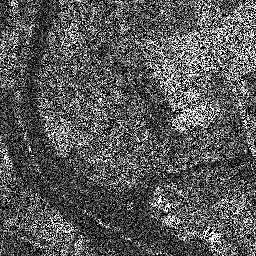

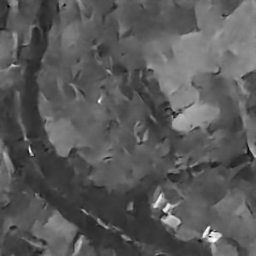

In [ ]:
tni = tni.detach().numpy()
cl = cl.detach().numpy()
cv2_imshow(tni)
cv2_imshow(cl)

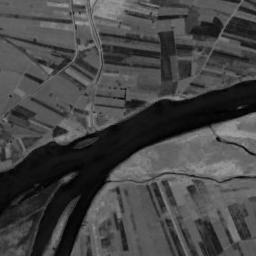

In [ ]:
cv2_imshow(cv2.imread('/content/drive/MyDrive/sar-images/clean_1c/23011.jpg'))